In [1]:
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import seaborn as sns

import sys
sys.path.insert(0,'/home/gsoc0/Adversarial_CapsNet_Pytorch/')
from model.net import *
from model.cnn_net import *
from utils.training import *
from data.data import *

## Experiment Config

In [2]:
model_path = os.path.join(os.getcwd(), "weights")

args = {
    'DATASET_NAME':'mnist',
    'num_classes':10,
    
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 512,
#     'N_EPOCHS': 100,
#     'LEARNING_RATE_1': 1e-2,
#     'LEARNING_RATE_2': 1e-2,
#     'WEIGHTDECAY':5e-6,
#     #Scheduler
#     'USE_SCHEDULER':True,
#     'sched_milestones':[14,25,30,40,50],
#     'sched_gamma':0.1,
    
#     #Loss Function
#     'LAMBDA_recon': 0.5,
#     'LAMBDA_class': 1,
    
    ##For Decoder
    'num_features':160,
    'LReLU_negative_slope':0.1,
    'input_height':28,
    'input_width':28,
    'input_channel':1,
    'type':'plusR',
    
}

#Setting Default Cuda Device
torch.cuda.set_device(2)

## Model Loading

In [3]:
#Modified Reconstructor

class Reconstructor(nn.Module):
    def __init__(self, net, args):
        super(Reconstructor, self).__init__()
        self.args = args
        self.reconstraction_layers = net.decoder.reconstraction_layers
        self.mean = torch.tensor(0.1307)
        self.std = torch.tensor(0.3081)
        if(args['USE_CUDA']):
            self.mean = self.mean.cuda()
            self.std = self.std.cuda()
        self.unnormalize = UnNormalize(self.mean, self.std)
        
#     def forward(self, x, data):
# #         classes = torch.sqrt((x ** 2).sum(2))
# #         classes = F.softmax(classes.squeeze(), dim=1)
# #         _, max_length_indices = classes.max(dim=1)
#         eye = torch.sparse.torch.eye(10)
#         if USE_CUDA:
#             eye = eye.cuda()
#         reconstructions_of_digits = []
#         for i in range(0,x.size(1)):
#             index_list = torch.ones((x.size(0), ),dtype=torch.int64).cuda()*i
#             masked = eye.index_select(dim=0, index=index_list)
#             reconstructions_of_digits.append(self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), 1, -1)))
        
#         reconstructions_of_digits = torch.cat(reconstructions_of_digits, dim=1) #shape = [B, 10, 28*28*1]
#         expanded_data = data.view(x.size(0), 1, -1).expand(-1, 10, -1)
#         unnormalized_data = self.unnormalize(expanded_data)
#         l2_distances = torch.square((unnormalized_data - reconstructions_of_digits)).sum(dim=(list(range(0, len(expanded_data.shape)))[2:]))
# #         reconstructions = reconstructions.view(-1, x.size(1), self.input_channel, self.input_width, self.input_height)
#         return l2_distances

    def forward(self, x, data):
        with torch.no_grad():
            classes = torch.sqrt((x ** 2).sum(2))
            classes = F.softmax(classes.squeeze(), dim=1)
            _, max_length_indices = classes.max(dim=1)
            max_length_indices_incorrect = 9 - max_length_indices
            eye = torch.sparse.torch.eye(10)
            if USE_CUDA:
                eye = eye.cuda()
            reconstructions_of_digits = []
            list_of_indices = [max_length_indices, max_length_indices_incorrect]
            for i, index_list in enumerate(list_of_indices):
                masked = eye.index_select(dim=0, index=index_list.squeeze().data)
                reconstructions_of_digits.append(self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), 1, -1)))

            reconstructions_of_digits = torch.cat(reconstructions_of_digits, dim=1) 
            expanded_data = data.view(x.size(0), 1, -1).expand(-1, len(list_of_indices), -1)
            unnormalized_data = self.unnormalize(expanded_data)
    #         img1 = data[0].reshape(28,28)
    #         img2 = reconstructions_of_digits[0][0].reshape(28, 28)
    #         img3 = reconstructions_of_digits[0][1].reshape(28, 28)
    #         imshow(img1)
    #         imshow(img2)
    #         imshow(img3)
            l2_distances = torch.square((unnormalized_data - reconstructions_of_digits)).sum(dim=(list(range(0, len(expanded_data.shape)))[2:]))
            return l2_distances
    
    def adversarial_recon(self, x, data, target):
        with torch.no_grad():
            eye = torch.sparse.torch.eye(10)
            if USE_CUDA:
                eye = eye.cuda()
            reconstructions_of_digits = []
            list_of_indices = [target]
            for i, index_list in enumerate(list_of_indices):
                masked = eye.index_select(dim=0, index=index_list.squeeze().data)
                reconstructions_of_digits.append(self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), 1, -1)))

            reconstructions_of_digits = torch.cat(reconstructions_of_digits, dim=1)
            expanded_data = data.view(x.size(0), 1, -1).expand(-1, len(list_of_indices), -1)
            unnormalized_data = self.unnormalize(expanded_data)
    #         img1 = data[0].reshape(28,28)
    #         img2 = reconstructions_of_digits[0][0].reshape(28, 28)
    #         img3 = reconstructions_of_digits[0][1].reshape(28, 28)
    #         imshow(img1)
    #         imshow(img2)
    #         imshow(img3)
            l2_distances = torch.square((unnormalized_data - reconstructions_of_digits)).sum(dim=(list(range(0, len(expanded_data.shape)))[2:]))
            return l2_distances
    
def imshow(img):
#     img = img * 0.3081 + 0.1307     # unnormalize
    npimg = img.cpu().numpy()
#     plt.imshow(np.transpose(npimg)#, (1, 2, 0)))
    plt.imshow(npimg)
    plt.show()

In [4]:
class Config:
    def __init__(self, dataset='mnist'):
        # CNN (cnn)
        self.cnn_in_channels = 1
        self.cnn_out_channels = 12
        self.cnn_kernel_size = 15

        # Primary Capsule (pc)
        self.pc_num_capsules = 1
        self.pc_in_channels = 12
        self.pc_out_channels = 16
        self.pc_kernel_size = 8
        self.pc_num_routes = 7 * 7

        # Digit Capsule 1 (dc)
        self.dc_num_capsules = 49
        self.dc_num_routes = 7 * 7
        self.dc_in_channels = 16
        self.dc_out_channels = 16 #1
        
        # Digit Capsule 2 (dc)
        self.dc_2_num_capsules = 10
        self.dc_2_num_routes = 7 * 7
        self.dc_2_in_channels = 16 #1
        self.dc_2_out_channels = 16

        # Decoder
        self.input_width = 28
        self.input_height = 28
torch.manual_seed(1)
config = Config()

net = CapsNet(args, config)
# capsule_net = torch.nn.DataParallel(capsule_net)
if args['USE_CUDA']:
    net = net.cuda()
    
net.load_state_dict(torch.load(os.path.join(model_path, 'CapsNet_mnist.pth'), map_location='cpu'))

<All keys matched successfully>

## Loading Dataset

In [5]:
trainloader, testloader = dataset(args)
for data in trainloader:
    print(data[0][0].min())
    print(data[0][0].max())
    break

tensor(-0.4242)
tensor(2.8215)


##  The histogram of L2 distances between the input and the reconstruction using the
## correct capsule or other capsules in CapsNet on the real MNIST images. 

In [6]:
import matplotlib.pyplot as plt
from advertorch.attacks import LinfPGDAttack

class Model_for_Adversary(nn.Module):
    def __init__(self, net):
        super(Model_for_Adversary, self).__init__()
        self.net = net
        
    def forward(self, x):
        output, recons, masked = self.net(x)
        classes = torch.sqrt((output ** 2).sum(2)).squeeze()
        return classes

def L2_Distances(net, reconstructor, train_loader, adversary, args):
    net.eval()
    n_batch = len(train_loader)
    l2_distances_correct_incorrect = []
    l2_distances_clean_adversarial = []
    
    for batch_id, (data, target) in enumerate(tqdm(train_loader)):
        if(args['USE_CUDA']):
            data, target = data.cuda(), target.cuda()

        adv_data = adversary.perturb(data, target)
        output, _, _ = net(data)        
        l2_distances_correct_incorrect.append(reconstructor(output, data).view(-1, ))
        output, _, _ = net(adv_data)
        l2_distances_clean_adversarial.append(reconstructor.adversarial_recon(output, adv_data, target).view(-1, ).detach())

        
    l2 = {}
    l2['correct_incorrect'] = torch.cat(l2_distances_correct_incorrect, dim=0).cpu().numpy()
    l2['clean_adversarial'] = torch.cat(l2_distances_clean_adversarial, dim=0).cpu().numpy()
    
    return l2['correct_incorrect'], l2['clean_adversarial']

In [7]:
recon = Reconstructor(net, args)
model_for_adversary = Model_for_Adversary(net)
    
adversary = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.3,
    nb_iter=15, eps_iter=0.01, rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

l2_distances = L2_Distances(net, recon, testloader, adversary, args)

100%|██████████| 20/20 [05:24<00:00, 16.21s/it]


(0, 200)

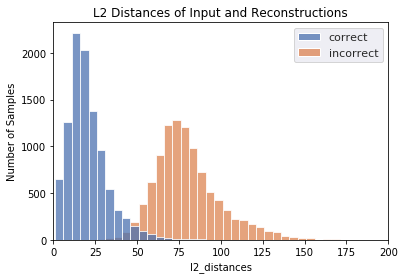

In [9]:
correct_l2 = l2_distances[0][list(range(0,20000,2))]
incorrect_l2 = l2_distances[0][list(range(1,19999,2))]

fig, ax = plt.subplots()
sns.set_theme()
sns.histplot({'correct':correct_l2, 'incorrect':incorrect_l2}, bins=range(1, 200, 5), ax=ax, kde=False)
ax.set_xlabel('l2_distances')
ax.set_ylabel('Number of Samples')
ax.set_title('L2 Distances of Input and Reconstructions')
ax.set_xlim([0, 200])

(0, 200)

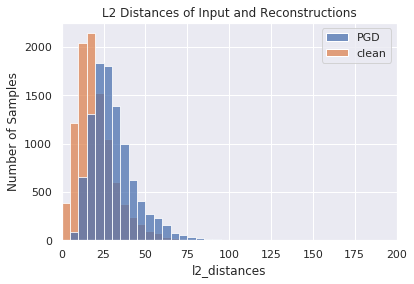

In [11]:
PGD_l2 = l2_distances[1]#[list(range(1,19999,2))]

fig, ax = plt.subplots()
sns.set_theme()
sns.histplot({ 'PGD':PGD_l2, 'clean':correct_l2 }, bins=range(0, 200, 5), ax=ax, kde=False)
ax.set_xlabel('l2_distances')
ax.set_ylabel('Number of Samples')
ax.set_title('L2 Distances of Input and Reconstructions')
ax.set_xlim([0, 200])

## Histograms for CNN + CR

In [7]:
args = {
    'DATASET_NAME':'mnist',
    'num_classes':10,
    
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 256,
    'N_EPOCHS': 100,
    'LEARNING_RATE_1': 1e-2,
    'LEARNING_RATE_2': 1e-2,
    'WEIGHTDECAY':5e-6,
    
    #Scheduler
    'USE_SCHEDULER':True,
    'sched_milestones':[8,20,30,40,50],
    'sched_gamma':0.1,
    
    #Loss Function
    'LAMBDA_recon': 0.5,
    'LAMBDA_class': 1,
    
    #For Decoder
    'num_features':160,
    'LReLU_negative_slope':0.1,
    'input_height':28,
    'input_width':28,
    'input_channel':1,
    'type':'plusCR',
    
}

In [8]:
class Config:
    def __init__(self, dataset='mnist'):
        # CONV1
        self.conv1_in = 1
        self.conv1_out = 12
        self.conv1_kernel_size = 15

        # CONV2
        self.conv2_in = 12
        self.conv2_out = 16
        self.conv2_kernel_size = 8

        # FC1
        self.fc1_in = 7 * 7 * 16
        self.fc1_out = 784
        
        # FC1
        self.fc2_in = 784
        self.fc2_out = 160

torch.manual_seed(2)
config = Config()

net = CNNnet(args, config)

# net = torch.nn.DataParallel(net)
net.load_state_dict(torch.load(os.path.join(model_path, 'CNNplusCR_mnist.pth'), map_location='cpu'))
    
if args['USE_CUDA']:
    net = net.cuda()
    

In [9]:
#Modified Reconstructor

class Reconstructor(nn.Module):
    def __init__(self, net, args):
        super(Reconstructor, self).__init__()
        self.args = args
        self.reconstraction_layers = net.decoder.reconstraction_layers
        self.mean = torch.tensor(0.1307)
        self.std = torch.tensor(0.3081)
        if(args['USE_CUDA']):
            self.mean = self.mean.cuda()
            self.std = self.std.cuda()
        self.unnormalize = UnNormalize(self.mean, self.std)

    def forward(self, x, data):
        with torch.no_grad():
            classes = x.sum(2)
            classes = F.softmax(classes.squeeze(), dim=1)
            _, max_length_indices = classes.max(dim=1)

            if(self.args['type']=='plusCR'):
                masked = torch.sparse.torch.eye(10)
                if USE_CUDA:
                    masked = masked.cuda()
                masked = masked.index_select(dim=0, index=max_length_indices.squeeze().data)
                t = (x * masked[:, :, None]).view(x.size(0), -1)
                reconstructions = self.reconstraction_layers(t)
                reconstructions = reconstructions.view(-1, 1, self.args['input_channel']* self.args['input_width']* self.args['input_height'])

            elif(self.args['type']=='plusR'):
                x = x.view(x.size(0), -1)
                reconstructions = self.reconstraction_layers(x)
                reconstructions = reconstructions.view(-1, 1, self.args['input_channel']* self.args['input_width']* self.args['input_height'])
            
            expanded_data = data.view(x.size(0), 1, -1).expand(-1, 1, -1)
            unnormalized_data = self.unnormalize(expanded_data)
            l2_distances = torch.square((unnormalized_data - reconstructions)).sum(dim=(list(range(0, len(expanded_data.shape)))[2:]))
            return l2_distances
    
    def adversarial_recon(self, x, data, target):
        with torch.no_grad():
            if(self.args['type']=='plusCR'):
                masked = torch.sparse.torch.eye(10)
                if USE_CUDA:
                    masked = masked.cuda()
                masked = masked.index_select(dim=0, index=target.squeeze().data)
                t = (x * masked[:, :, None]).view(x.size(0), -1)
                reconstructions = self.reconstraction_layers(t)
                reconstructions = reconstructions.view(-1, 1, self.args['input_channel']* self.args['input_width']* self.args['input_height'])
            
                
            elif(self.args['type']=='plusR'):
                x = x.view(x.size(0), -1)
                reconstructions = self.reconstraction_layers(x)
                reconstructions = reconstructions.view(-1, 1, self.args['input_channel']* self.args['input_width']* self.args['input_height'])
            
            expanded_data = data.view(x.size(0), 1, -1).expand(-1, 1, -1)
            unnormalized_data = self.unnormalize(expanded_data)
            l2_distances = torch.square((unnormalized_data - reconstructions)).sum(dim=(list(range(0, len(expanded_data.shape)))[2:]))
            return l2_distances


In [10]:
class Model_for_Adversary(nn.Module):
    def __init__(self, net):
        super(Model_for_Adversary, self).__init__()
        self.net = net
        
    def forward(self, x):
        output, recons, masked = self.net(x)
        classes = output.sum(2)
        return classes
    
def L2_Distances(net, reconstructor, train_loader, adversary, args):
    net.eval()
    n_batch = len(train_loader)
    l2_distances_clean = []
    l2_distances_adversarial = []
    
    for batch_id, (data, target) in enumerate(tqdm(train_loader)):
        if(args['USE_CUDA']):
            data, target = data.cuda(), target.cuda()

        adv_data = adversary.perturb(data, target)
        output, _, _ = net(data)
        l2_distances_clean.append(reconstructor.adversarial_recon(output, data, target).view(-1, ).detach())
        output, _, _ = net(adv_data)
        l2_distances_adversarial.append(reconstructor.adversarial_recon(output, adv_data, target).view(-1, ).detach())

        
    l2 = {}
    l2['clean'] = torch.cat(l2_distances_clean, dim=0).cpu().numpy()
    l2['adversarial'] = torch.cat(l2_distances_adversarial, dim=0).cpu().numpy()
    
    return l2['clean'], l2['adversarial']

In [11]:
recon = Reconstructor(net, args)
model_for_adversary = Model_for_Adversary(net)
    
adversary = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.3,
    nb_iter=100, eps_iter=0.01, rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

l2_distances = L2_Distances(net, recon, testloader, adversary, args)

100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


(0, 200)

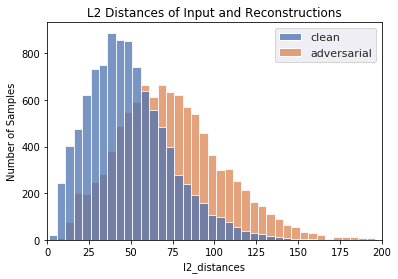

In [12]:
clean_l2 = l2_distances[0]#[list(range(0,20000,2))]
adversarial_l2 = l2_distances[1]#[list(range(1,19999,2))]

fig, ax = plt.subplots()
sns.set_theme()
sns.histplot({'clean':clean_l2, 'adversarial':adversarial_l2}, bins=range(1, 200, 5), ax=ax, kde=False)
ax.set_xlabel('l2_distances')
ax.set_ylabel('Number of Samples')
ax.set_title('L2 Distances of Input and Reconstructions')
ax.set_xlim([0, 200])

## Histograms for CNN plus R

In [13]:
args = {
    'DATASET_NAME':'mnist',
    'num_classes':10,
    
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 256,
    'N_EPOCHS': 100,
    'LEARNING_RATE_1': 1e-2,
    'LEARNING_RATE_2': 1e-2,
    'WEIGHTDECAY':5e-6,
    
    #Scheduler
    'USE_SCHEDULER':True,
    'sched_milestones':[8,20,30,40,50],
    'sched_gamma':0.1,
    
    #Loss Function
    'LAMBDA_recon': 0.5,
    'LAMBDA_class': 1,
    
    #For Decoder
    'num_features':160,
    'LReLU_negative_slope':0.1,
    'input_height':28,
    'input_width':28,
    'input_channel':1,
    'type':'plusR',
    
}

In [14]:
class Config:
    def __init__(self, dataset='mnist'):
        # CONV1
        self.conv1_in = 1
        self.conv1_out = 12
        self.conv1_kernel_size = 15

        # CONV2
        self.conv2_in = 12
        self.conv2_out = 16
        self.conv2_kernel_size = 8

        # FC1
        self.fc1_in = 7 * 7 * 16
        self.fc1_out = 784
        
        # FC1
        self.fc2_in = 784
        self.fc2_out = 160

torch.manual_seed(2)
config = Config()

net = CNNnet(args, config)

# net = torch.nn.DataParallel(net)
net.load_state_dict(torch.load(os.path.join(model_path, 'CNNplusR_mnist.pth'), map_location='cpu'))
    
if args['USE_CUDA']:
    net = net.cuda()
    

In [16]:
recon = Reconstructor(net, args)
model_for_adversary = Model_for_Adversary(net)
    
adversary = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.3,
    nb_iter=1000, eps_iter=0.01, rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

l2_distances = L2_Distances(net, recon, testloader, adversary, args)

100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


(0, 200)

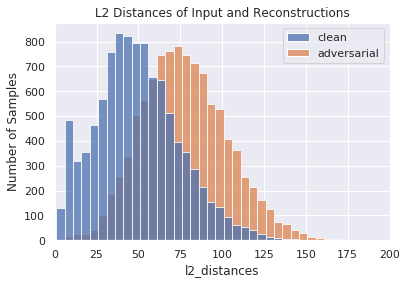

In [19]:
clean_l2 = l2_distances[0]#[list(range(0,20000,2))]
adversarial_l2 = l2_distances[1]#[list(range(1,19999,2))]

fig, ax = plt.subplots()
sns.set_theme()
sns.histplot({'clean':clean_l2, 'adversarial':adversarial_l2}, bins=range(1, 200, 5), ax=ax, kde=False)
ax.set_xlabel('l2_distances')
ax.set_ylabel('Number of Samples')
ax.set_title('L2 Distances of Input and Reconstructions')
ax.set_xlim([0, 200])